# HPC data: Job Table Exploration

We are working on the data dump of the acquistion period from 03/01/22 to 04/01/22.

The data is available at https://zenodo.org/record/7590061

After downloading it, it sufficient to extract it with the command ```tar -xvf 22.03.tar ```. 

We are only interested to the job table, for simplicity we moved a copy out of the directory tree to access it easily, but it can be easily queried using the ```query-tool``` that you developed.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

DATA_PATH = 'job_table.parquet'
df = pd.read_parquet(DATA_PATH)
df.head()

,accrue_time,alloc_node,alloc_sid,array_job_id,array_max_tasks,array_task_id,array_task_str,array_task_throttle,assoc_id,batch_flag,...,tres_bind,tres_freq,tres_per_job,tres_per_node,tres_per_socket,tres_per_task,tres_req_str,user_id,wait4switch,wckey
0,NaT,None,NaN,1545290,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:1,None,None,None,393,NaN,None
1,NaT,None,NaN,4840800,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:1,None,None,None,393,NaN,None
2,NaT,None,NaN,3928180,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:1,None,None,None,1234,NaN,None
3,NaT,None,NaN,4055635,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:4,None,None,None,1318,NaN,None
4,NaT,None,NaN,5945770,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:1,None,None,None,1234,NaN,None


The relevant attributes of this dataframe are *start_time*, *end_time* and *nodes*.

Duration for each job can be simply computed as the difference between end and start time.

The list of allocated nodes for each job is available at the column *nodes* in a string format. First thing we do is to convert it to a numpy array. 
Then we compute the edge list for each job, simply assuming a complete, undirected graph involving each of the nodes allocated

Some jobs contain an empty nodes list. For the moment, we are ignoring these, and we collect all the edges in ```true_edges```

In [2]:
df = df.dropna(subset=['nodes'])
print("Data covering the period from {} to {}".format(df.start_time.min().date(),df.end_time.max().date()))
df['duration'] = df.end_time-df.start_time
df.nodes = df.nodes.map(lambda x:np.fromstring(x.strip(']['),dtype=int,sep=',')) # map nodelist from str to array
edge_list = df.nodes.map(lambda x: list(itertools.permutations(x,2))) # build edgelist for each node
true_edges = np.concatenate((edge_list[edge_list.map(len) > 0]).values) # remove empty list and collect all

Data covering the period from 2022-03-31 to 2022-04-30


To help visualize links, we can build a heatmap counting how many occurences of a link $(i,j)$ appear for each pair of nodes $i,j$

In [3]:
def build_heatmap(edges):
    # Find the maximum node index to determine the dimensions of the heatmap matrix
    max_node = np.max(edges)
    
    # Initialize the heatmap matrix with zeros
    heatmap = np.zeros((max_node + 1, max_node + 1), dtype=int)
    
    # Increment the corresponding cells in the heatmap matrix
    np.add.at(heatmap, (edges[:, 0], edges[:, 1]), 1)
    return heatmap

def plot_heatmap(heatmap,
                 amin = 0,
                 amax = None,
                 title = 'Link Frequency Heatmap',
                 major_ticks = None,
                 minor_ticks = None
                 ):
    
    fig = plt.figure(figsize=(16,14))
    ax = fig.add_subplot(1,1,1)
    plt.title(title)
    
    if amax is None:
        amax = amin+len(heatmap)
    img = ax.imshow(heatmap[amin:amax,amin:amax],extent=[amin-.5,amax-.5,amin-.5,amax-.5] ,cmap='cool', interpolation='nearest',origin='lower')
    fig.colorbar(img)
    ax.set_xlabel('Node')
    ax.set_ylabel('Node')
    
    if major_ticks is not None:
        ax.set_xticks(major_ticks-0.5)
        ax.set_xticklabels(major_ticks)
        ax.set_yticks(major_ticks-0.5)
        ax.set_yticklabels(major_ticks)
        ax.grid(which='major', alpha=0.5)

    if minor_ticks is not None:
        ax.set_xticks(minor_ticks-0.5, minor=True)
        ax.set_yticks(minor_ticks-0.5, minor=True)
        ax.grid(which='minor', alpha=0.2)

    # Or if you want different settings for the grids:
    plt.show()

# Build the heatmap
heatmap = build_heatmap(true_edges)

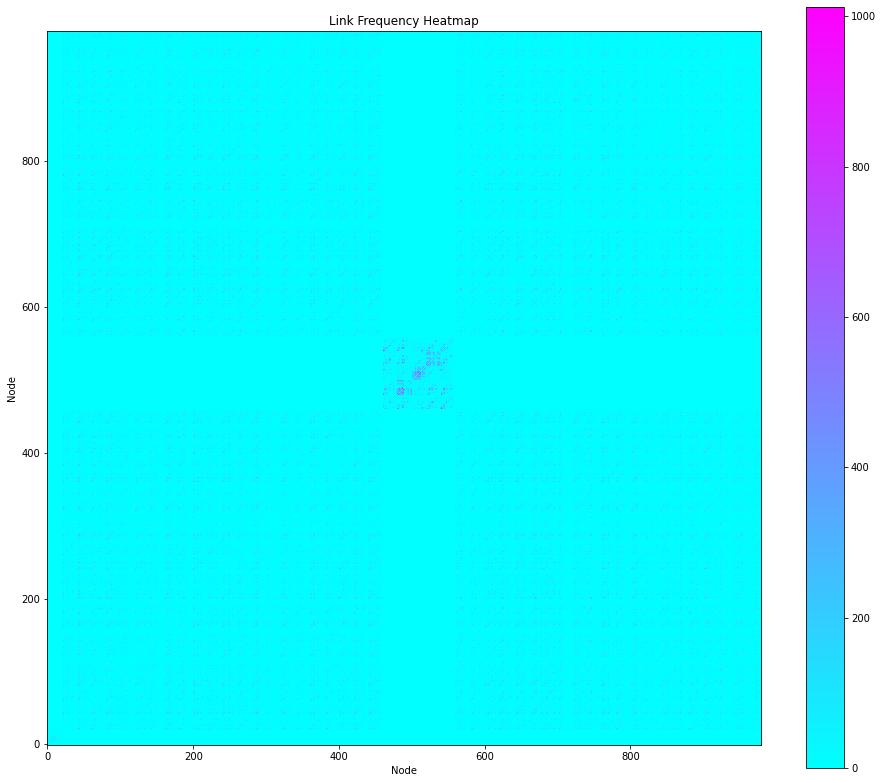

In [4]:
plot_heatmap(heatmap)

Some observations can be made on the basis of this heatmap:
- Jobs can receive the allocations of nodes from different racks, exceptions made for the nodes 0-19 (rack 0) and 460-559 (racks 23-28) which seem to be isolated from the rest
- Distribution of links is not uniform, especially it is highly unbalanced in nodes 460-559.

### Nodes 0-60

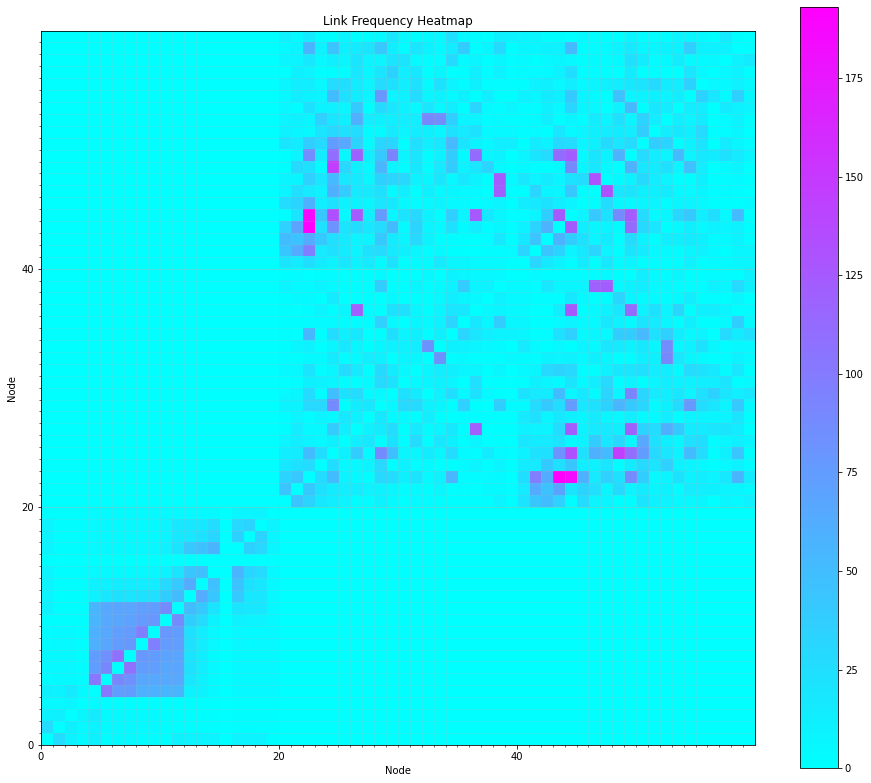

In [5]:
# Plot the heatmap
amin,amax = 0,60
major_ticks=np.arange(amin, amax, 20)

minor_ticks = np.arange(amin,amax, 1)
plot_heatmap(heatmap,amin,amax,major_ticks=major_ticks,minor_ticks=minor_ticks)

### Nodes 460-559

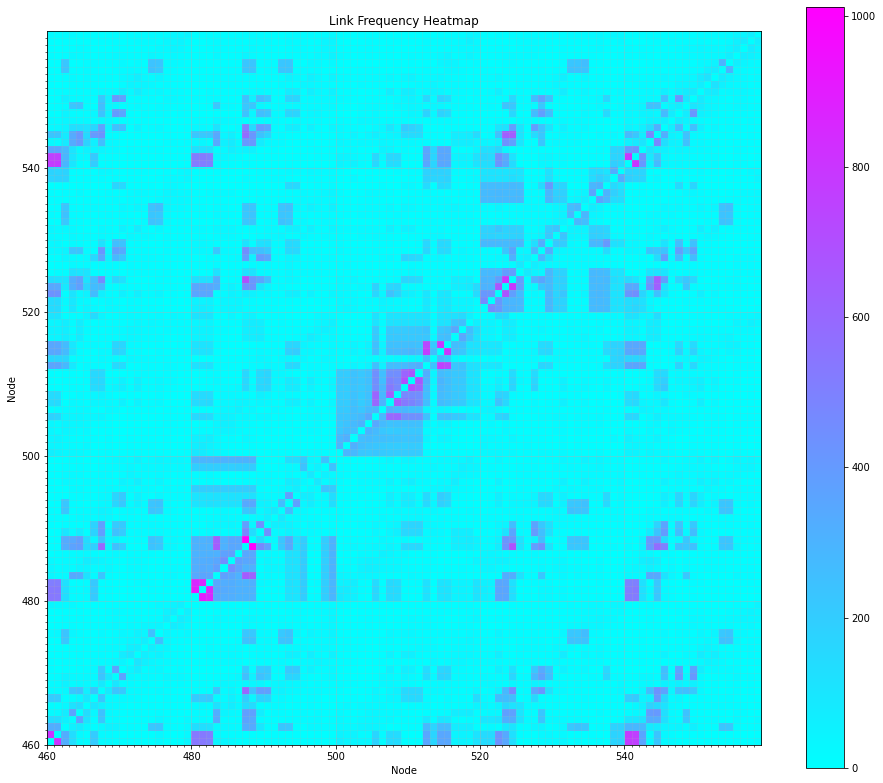

In [6]:
# Plot the heatmap
amin,amax = 460,559
major_ticks=np.arange(amin, amax, 20)
minor_ticks = np.arange(amin,amax, 1)
plot_heatmap(heatmap,amin,amax,major_ticks=major_ticks,minor_ticks=minor_ticks)

We want to compute some metrics to better analyze this unbalanced distribution. 
Here we show metrics for nodes 0-60 only, if you want to have a complete look just set ```amin,amax``` as you like

In [30]:
amin,amax = 0,60
nids = np.arange(amin,amax)
rack0 = df[df.nodes.map(lambda n : any(e in range(amin,amax) for e in n))]
counts = np.zeros(amax-amin)
durations_mean = np.zeros(amax-amin)
durations_total = np.zeros(amax-amin)

for node in tqdm(range(amin,amax)):
    mask = rack0.nodes.map(lambda n : any(e==(node) for e in n))
    counts[node-amin] = mask.sum()
    durations=rack0[mask].duration.map(lambda x:x.seconds/60)
    durations_mean[node-amin] = durations.mean()
    durations_total[node-amin] = durations.sum()

100%|██████████| 60/60 [00:03<00:00, 19.80it/s]


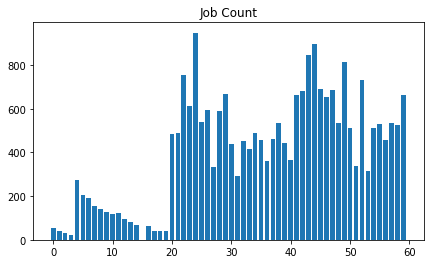

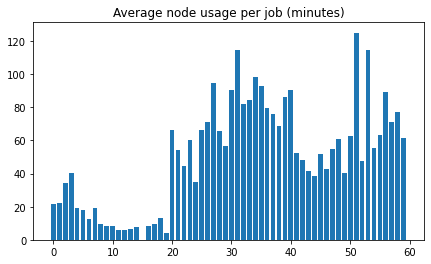

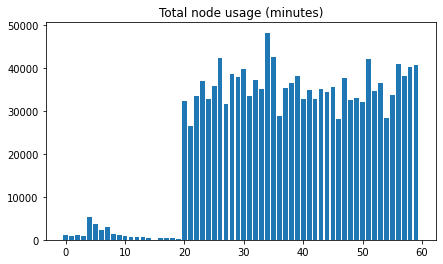

In [31]:
def show_counts(counts,title = "",xticks = None,figsize = None):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    plt.bar(nids,counts)
    plt.xticks(xticks)
    plt.show()


figsize = (7,4)
show_counts(counts,'Job Count',figsize=figsize)
show_counts(durations_mean,'Average node usage per job (minutes)',figsize=figsize)
show_counts(durations_total,'Total node usage (minutes)',figsize=figsize)

## Include Metrics

In [10]:
node_metrics = pd.read_parquet('all_metrics.parquet')
node_metrics = node_metrics[(node_metrics.timestamp >= df.start_time.min()) & (node_metrics.timestamp <= df.end_time.max())]


In [11]:
print(node_metrics.timestamp.min(),node_metrics.timestamp.max())
print(df.start_time.min(),df.end_time.max())

2022-03-31 02:45:00+00:00 2022-04-30 23:45:00+00:00
2022-03-31 02:30:12+00:00 2022-04-30 23:56:57+00:00


In [12]:
node_metrics.head()

,timestamp,2,3,4,5,6,7,8,9,10,11,13,14,16,17,18,19,values
0,2022-03-31 02:45:00+00:00,"[22.182225206163196, 0.15098023414611816, 22.0...","[22.37333034939236, 0.14360417425632477, 22.20...","[23.079999457465277, 0.09797996282577515, 23.0...","[23.435552300347222, 0.10573680698871613, 23.2...","[24.617781575520834, 0.10173776745796204, 24.3...","[23.240003797743057, 0.09977716207504272, 23.0...","[23.11555447048611, 0.1228470653295517, 23.0, ...","[22.879999457465278, 0.09797996282577515, 22.7...",None,None,"[22.69333224826389, 0.10832001268863678, 22.60...","[22.457774522569444, 0.0999755784869194, 22.20...","[22.17778049045139, 0.16450437903404236, 22.0,...","[22.457774522569444, 0.11640728265047073, 22.2...","[22.875553385416666, 0.10573709011077881, 22.7...","[23.231114366319446, 0.12617814540863037, 23.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, ..."
1,2022-03-31 03:00:00+00:00,"[22.28000217013889, 0.11469721794128418, 22.0,...","[22.466663953993056, 0.11155489087104797, 22.2...","[23.164444986979166, 0.07646540552377701, 23.0...","[23.5066650390625, 0.09977791458368301, 23.399...","[24.640001085069443, 0.07999954372644424, 24.6...","[23.2933349609375, 0.09977696090936661, 23.200...","[23.160001627604167, 0.08000030368566513, 23.0...","[22.951112196180556, 0.0859517902135849, 22.79...",None,None,"[22.733331976996528, 0.10327907651662827, 22.6...","[22.51999782986111, 0.09797996282577515, 22.39...","[22.26666937934028, 0.1264907419681549, 22.0, ...","[22.546663411458333, 0.08844366669654846, 22.3...","[22.955555555555556, 0.08314825594425201, 22.7...","[23.328892686631946, 0.09573571383953094, 23.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, ..."
2,2022-03-31 03:15:00+00:00,"[22.33778076171875, 0.09258910268545151, 22.20...","[22.51555718315972, 0.09878309071063995, 22.39...","[23.20888943142361, 0.0724865272641182, 23.0, ...","[23.559996202256944, 0.08000030368566513, 23.3...","[24.67555609809028, 0.09696577489376068, 24.60...","[23.342222764756944, 0.09064871817827225, 23.2...","[23.240001085069444, 0.10832017660140991, 23.0...","[22.97333441840278, 0.06798718124628067, 22.79...",None,None,"[22.79111056857639, 0.0838574469089508, 22.600...","[22.582218424479166, 0.08243225514888763, 22.3...","[22.324446614583334, 0.09696577489376068, 22.2...","[22.613331434461806, 0.07774581015110016, 22.3...","[23.035555013020833, 0.07646540552377701, 23.0...","[23.37333713107639, 0.06798654049634933, 23.20...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, ..."
3,2022-03-31 03:30:00+00:00,"[22.302225748697918, 0.11640667170286179, 22.0...","[22.4977783203125, 0.12380806356668472, 22.200...","[23.173334418402778, 0.08000018447637558, 23.0...","[23.537776692708334, 0.09258998185396194, 23.3...","[24.666666666666668, 0.09428036957979202, 24.6...","[23.333336046006945, 0.09428036957979202, 23.2...","[23.213335503472223, 0.1222018375992775, 23.0,...","[22.964444986979167, 0.07646540552377701, 22.7...",None,None,"[22.737775336371527, 0.09258910268545151, 22.6...","[22.524443901909724, 0.10573696345090866, 22.2...","[22.2888916015625, 0.12332791835069656, 22.0, ...","[22.559996202256944, 0.08000030368566513, 22.3...","[22.964444986979167, 0.07646540552377701, 22.7...","[23.346668836805556, 0.10666633397340775, 23.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, ..."
4,2022-03-31 03:45:00+00:00,"[22.35111355251736, 0.08595097810029984, 22.20...","[22.55111355251736, 0.09573651850223541, 22.39...","[23.275556098090277, 0.12139070779085159, 23.0...","[23.568891059027777, 0.08385781198740005, 23.3...","[24.733333333333334, 0.09428036957979202, 24.6...","[23.4, 0.126490980386734, 23.200000762939453, ...","[23.333333333333332, 0.10327910631895065, 23.0...","[23.048887803819444, 0.11278779059648514, 22.7...",None,None,"[22.751108127170138, 0.12757927179336548, 22.3...","[22.542225477430556, 0.11640725284814835, 22.2...","[22.311112467447916, 0.13033635914325714, 22.0...","[22.635555013020834, 0.147806778550148, 22.399...","[23.057

In [13]:
window_size = 40
job_counts = []
from tqdm import tqdm 

for i in tqdm(range(len(node_metrics)-window_size)):
    window = node_metrics[i:i+window_size]
    tmin,tmax = window.timestamp.min(),window.timestamp.max()
    window_nodes = df[(df.start_time >=tmin) & (df.start_time <tmax)].nodes
    job_counts.append(len(window_nodes))

100%|██████████| 2923/2923 [00:24<00:00, 120.71it/s]


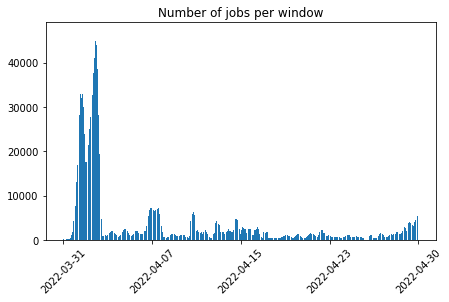

In [14]:
plt.figure(figsize = figsize)
plt.title('Number of jobs per window')
plt.bar(range(len(job_counts)),job_counts) 
plt.xticks(np.linspace(0,len(job_counts),5),
            labels=pd.date_range(start=df.start_time.min(),end=df.start_time.max(),periods=5).map(lambda x : x.date),
            rotation = 45)
plt.show()

## Observe the topology for a "random" time window
(We're actually intentionally selecting a window with a high number of nodes)

In [15]:
i = 500
window = node_metrics[i:i+window_size]
tmin,tmax = window.timestamp.min(),window.timestamp.max()

window_nodes = df[(df.start_time >=tmin) & (df.start_time <tmax)].nodes
edge_list = window_nodes.map(lambda x: list(itertools.permutations(x,2))) # build edgelist for each node
true_edges = np.concatenate((edge_list[edge_list.map(len) > 0]).values) # remove empty list and collect all

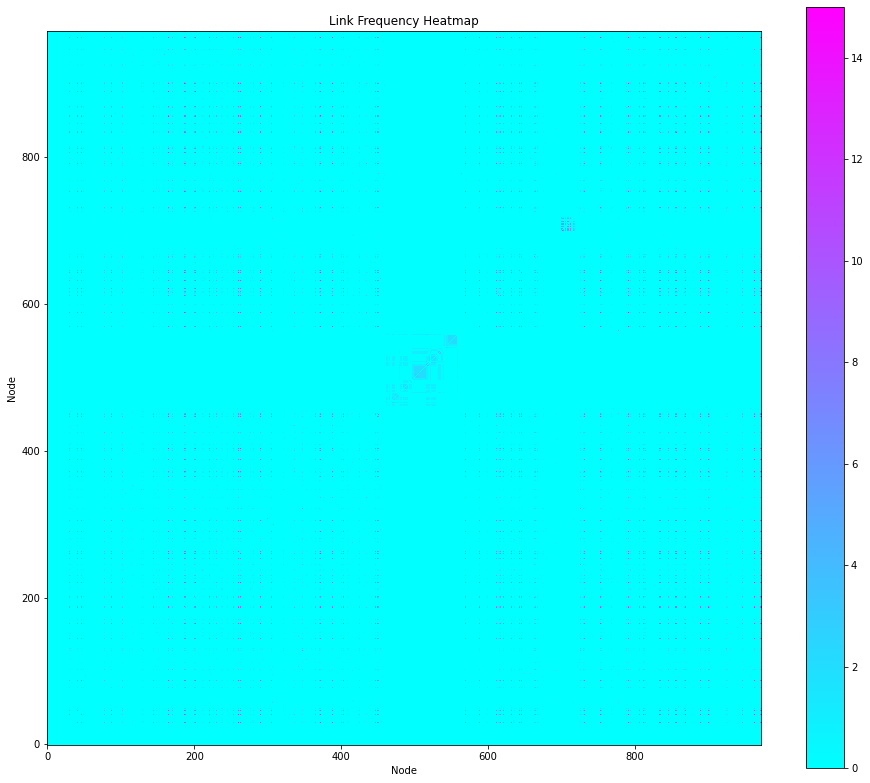

In [16]:
heatmap = build_heatmap(true_edges)

plot_heatmap(heatmap)

We build the graph using ```dgl``` then export it to ```networkx```, but the preferred implementation doesn't really matter.

In [17]:
import dgl
import networkx as nx
edgelist = np.unique(true_edges,axis = 0)
graph = dgl.graph((edgelist[:,0],edgelist[:,1]),num_nodes = 980)
G = dgl.to_networkx(graph)
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
    'pos': nx.spring_layout(G,iterations=10)
}

In [18]:
def draw_graph(G):
    positions = np.array([(np.cos(theta),np.sin(theta) ) for theta in np.linspace(np.pi/2,-3*np.pi/2,G.number_of_nodes())])
    pos_mapping = {node:positions[idx] for idx,node in enumerate([(g[0]) for g in sorted(G.degree,key=lambda x:x[1],reverse=True)])}
    edgelist = list(G.edges)
    plt.figure(figsize = (10,10))
    plt.scatter(positions[:,0],positions[:,1],s=0.1) 
    for edge in edgelist:
        src,dst,_= edge
        x0,y0 = pos_mapping[src]
        x1,y1 = pos_mapping[dst]

        plt.plot([x0,x1],[y0,y1],linewidth=0.01,color='black')
    plt.axis('off')

We plot the graph. nodes are sorted according to the degree. Even with a high number of active jobs, most nodes are isolated.

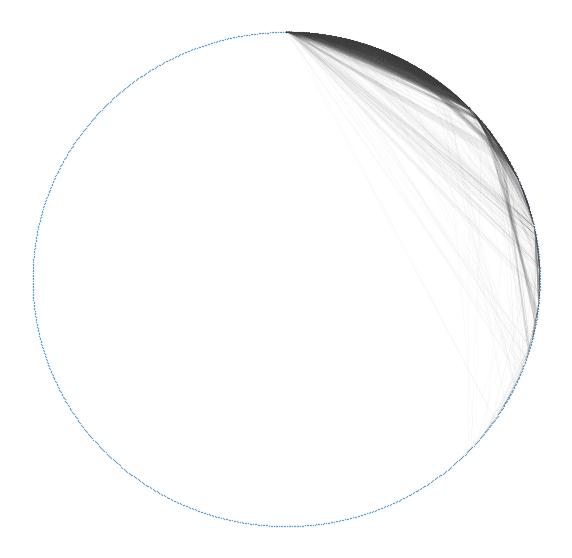

In [19]:
draw_graph(G)

## Build total graph

In [61]:
import torch
src,dst = np.nonzero(heatmap)
graph = dgl.graph((src,dst),num_nodes=980)
eweights = torch.tensor(heatmap[heatmap.nonzero()],dtype=float)
eweights /= eweights.max()

nodes = true_edges.reshape(-1)
nweights = torch.tensor([np.count_nonzero(nodes == i) for i in range(980)])
graph.edata['eweight'] = eweights
graph.ndata['nweight'] = nweights